In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions


In [3]:
#Mount the google drive:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#Check the directory:
cd /content/drive/My Drive/Colab Notebooks/Six_Classes

/content/drive/My Drive/Colab Notebooks/Six_Classes


In [0]:
WIDTH=299
HEIGHT=299
BATCH_SIZE=64
test_dir = 'test/'
train_dir = 'train/'
val_dir = 'val/'

In [15]:
#Train DataSet Generator with Augmentation
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Training Data Set
Found 11209 images belonging to 6 classes.


In [6]:
#Validation DataSet Generator with Augmentation
print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Validation Data Set
Found 622 images belonging to 6 classes.


In [7]:
#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Test Data Set
Found 1256 images belonging to 6 classes.


In [0]:
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os

In [0]:
NUM_PARALLEL_EXEC_UNITS = 8


In [0]:
#Set Performance Parameters for MKL and Tensorflow using Keras backend
#TensorFlow
config = tf.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)

session = tf.Session(config=config)
K.set_session(session)

In [0]:
#MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

In [12]:
# Initialize InceptionV3 with transfer learning
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))













87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_model.output

In [0]:
x = GlobalAveragePooling2D()(x)
# and a dense layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='categorical_crossentropy')
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________

In [0]:
import math
top_layers_file_path="top_layers.iv3.hdf5"

In [0]:
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='./logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('./logs/iv3-log.csv', append=True)

In [24]:
history = model.fit_generator(train_flow, 
                              epochs=3, 
                              verbose=1,                         
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/3
  1/176 [..............................] - ETA: 2:18:17 - loss: 1.8698 - acc: 0.1406 - top_k_categorical_accuracy: 0.7812WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1265: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

176/176 [==============================] - 3637s 21s/step - loss: 0.6026 - acc: 0.7977 - top_k_categorical_accuracy: 0.9909 - val_loss: 1.0850 - val_acc: 0.6929 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: loss improved from inf to 0.60256, saving model to top_layers.iv3.hdf5
Epoch 2/3
176/176 [==============================] - 3661s 21s/step - loss: 0.2026 - acc: 0.9321 - top_k_categorical_accuracy: 0.9999 - val_loss: 1.4542 - val_acc: 0.6913 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: loss improved from 0.60256 to 0.20270, saving model to top_layers.iv3.hdf5
Epoch 3/3
176/176 

In [26]:
model.load_weights(top_layers_file_path)
loss, acc, top_5 = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/20 [=========>....................] - ETA: 9:23 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/20 [=====================>........] - ETA: 3:33

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/20 [==============================] - 849s 42s/step


In [27]:
print("Loss: ", loss)

Loss:  1.6115237535185116


In [28]:
print("Acc: ", acc)

Acc:  0.695859872611465


In [29]:
print("Top 5: ", top_5)

Top 5:  0.9976114649681529


In [0]:
label = [k for k,v in train_flow.class_indices.items()]

In [0]:
with open('iv3-labels.txt', 'w+') as file:
    file.write("\n".join(label))

In [0]:
from keras.preprocessing import image
import numpy as np
import glob
import random

In [0]:
file_list = glob.glob("test/*/*")

In [0]:
img_path = random.choice(file_list)

In [0]:
img_cat = os.path.split(os.path.dirname(img_path))[1]

In [36]:
print("Image Category: ", img_cat)

Image Category:  White-nosed_Coati


In [0]:
img = image.load_img(img_path, target_size=(299, 299))

In [0]:
x = image.img_to_array(img)

In [0]:
x = np.expand_dims(x, axis=0)

In [0]:
x = preprocess_input(x)

In [0]:
preds = model.predict(x)

In [42]:
print("Raw Predictions: ", preds)

Raw Predictions:  [[9.9079716e-01 1.3424299e-10 5.9693298e-06 2.2137892e-06 9.6429358e-05
  9.0981722e-03]]


In [0]:
top_x = 3

In [0]:
top_args = preds[0].argsort()[-top_x:][::-1]

In [0]:
preds_label = [label[p] for p in top_args]

In [46]:
print("\nTop " + str(top_x) + " confidence: " + " ".join(map(str, sorted(preds[0])[-top_x:][::-1])))


Top 3 confidence: 0.99079716 0.009098172 9.642936e-05


In [47]:
print("Top " + str(top_x) + " labels: " + " ".join(map(str, preds_label)))

Top 3 labels: Collared_Peccary White-nosed_Coati Red_Squirrel


In [0]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io


In [0]:
input_model_path = top_layers_file_path

In [0]:
output_model_name = "top_layers.iv3.pb"

In [0]:
output_model_dir = "tf_model"

In [0]:
K.set_learning_phase(0)
sess = K.get_session()

In [0]:
test_model = models.load_model(input_model_path)
orig_output_node_names = [node.op.name for node in test_model.outputs]

In [54]:
constant_graph = graph_util.convert_variables_to_constants(
    sess,
    sess.graph.as_graph_def(),
    orig_output_node_names)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 380 variables.
INFO:tensorflow:Converted 380 variables to const ops.


In [55]:
graph_io.write_graph(
    constant_graph,
    output_model_dir,
    output_model_name,
    as_text=False)

'tf_model/top_layers.iv3.pb'

In [0]:
from keras.models import load_model
model = load_model('top_layers.iv3.hdf5')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

In [0]:
#Test DataSet Generator with Augmentation
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [59]:
test_flow = test_generator.flow_from_directory(
    'test',
    shuffle=False,
    target_size=(299, 299),
    batch_size = 32
)

Found 1256 images belonging to 6 classes.


In [0]:
import math
import numpy as np

In [61]:
predictions = model.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
predicted_classes = np.argmax(predictions, axis=1) 

40/40 [==============================] - 320s 8s/step


In [0]:
true_classes = test_flow.classes

In [0]:
class_labels = list(test_flow.class_indices.keys())  

In [64]:
pip install scikit-plot

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import scikitplot as skplt

In [66]:
[print(k, ":", v) for k,v in enumerate(class_labels)]

0 : Collared_Peccary
1 : European_Hare
2 : Ocelot
3 : Red_Deer
4 : Red_Squirrel
5 : White-nosed_Coati


[None, None, None, None, None, None]

In [0]:
true_map_classes = [class_labels[x] for x in true_classes]

In [0]:
predicted_map_classes = [class_labels[x] for x in predicted_classes]

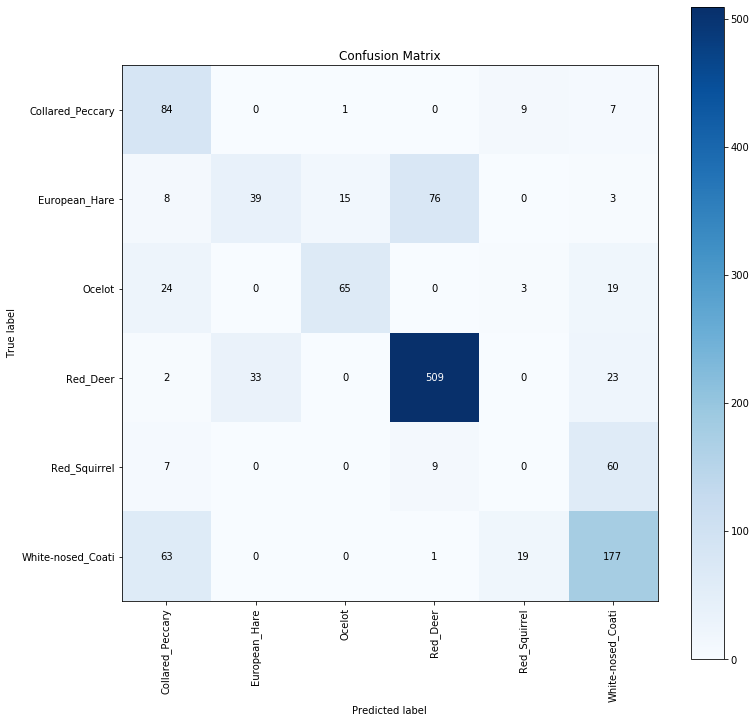

In [69]:
skplt.metrics.plot_confusion_matrix(
    true_map_classes, 
    predicted_map_classes,
    labels=class_labels,
    x_tick_rotation=90,
    figsize=(12,12))

In [0]:
from sklearn.metrics import classification_report

In [0]:
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels)

In [72]:
print(report)

                   precision    recall  f1-score   support

 Collared_Peccary       0.45      0.83      0.58       101
    European_Hare       0.54      0.28      0.37       141
           Ocelot       0.80      0.59      0.68       111
         Red_Deer       0.86      0.90      0.88       567
     Red_Squirrel       0.00      0.00      0.00        76
White-nosed_Coati       0.61      0.68      0.64       260

         accuracy                           0.70      1256
        macro avg       0.54      0.55      0.52      1256
     weighted avg       0.68      0.70      0.68      1256



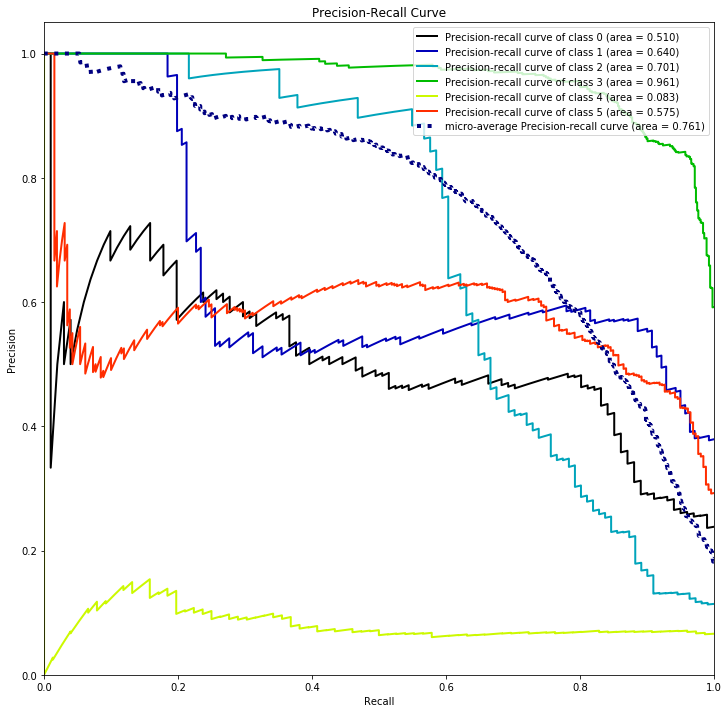

In [73]:
skplt.metrics.plot_precision_recall(
    true_classes,
    predictions,
    figsize=(12,12))

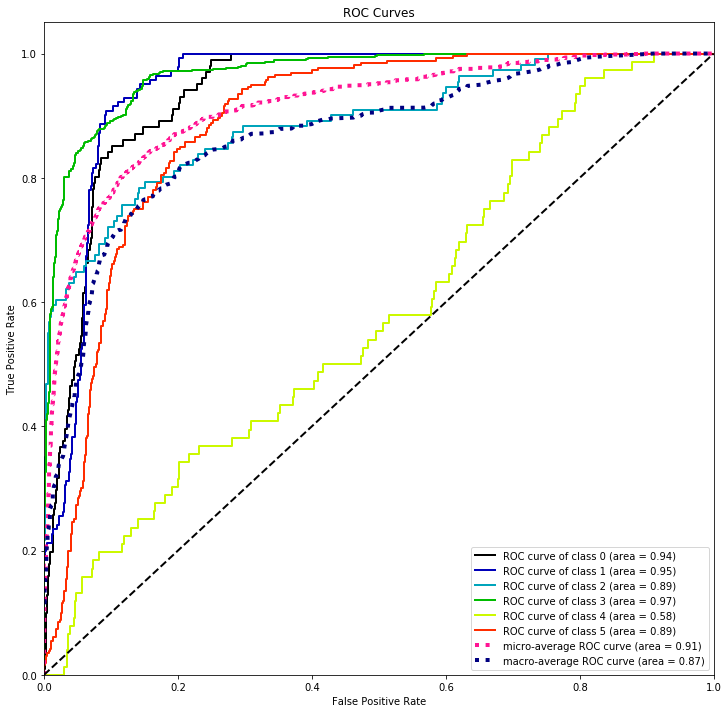

In [74]:
skplt.metrics.plot_roc(
    true_classes,
    predictions,
    figsize=(12,12))